In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras import layers, models
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import RMSprop, Adam
import keras_tuner as kt
from datetime import datetime
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

2024-07-16 21:55:24.830153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 21:55:24.830207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 21:55:24.831778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 21:55:24.839859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 21:55:25.603763: W tensorflow/compiler/tf2

In [2]:
# GPU Setup
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4'
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


2024-07-16 21:55:27.094900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-16 21:55:27.095400: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-16 21:55:27.095861: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:

#Labels and images for the LARGER 2015 dataset which was originally used to train the saved model
labels_2015_df = pd.read_csv('/home/nate/distributed_training/retinopathy_data/aptos-2015-training.csv')
image_paths_2015 = labels_2015_df['image'].apply(lambda x: os.path.join('/home/nate/distributed_training/retinopathy_data/train_resized', x + '.jpg')).tolist()
labels_2015 = labels_2015_df['level'].tolist()

# Load the new, smaller 2019 labels and image paths 
labels_2019_df = pd.read_csv('/home/nate/distributed_training/retinopathy_data/aptos_2019_train.csv')
image_paths_2019 = labels_2019_df['id_code'].apply(lambda x: os.path.join('/home/nate/distributed_training/retinopathy_data/2019_Aptos_images', x + '.jpg')).tolist()
labels_2019 = labels_2019_df['diagnosis'].tolist()

# Calculate the distribution of classes in the 2015 dataset
class_distribution_2015 = labels_2015_df['level'].value_counts().sort_index()

# Calculate the distribution of classes in the 2019 dataset
class_distribution_2019 = labels_2019_df['diagnosis'].value_counts().sort_index()


In [4]:
# Calculate the distribution of classes in the 2015 dataset
class_distribution_2015 = labels_2015_df['level'].value_counts().sort_index()
class_distribution_2015_percent = (class_distribution_2015 / class_distribution_2015.sum()) * 100

# Calculate the distribution of classes in the 2019 dataset
class_distribution_2019 = labels_2019_df['diagnosis'].value_counts().sort_index()
class_distribution_2019_percent = (class_distribution_2019 / class_distribution_2019.sum()) * 100

# Print the numerical and percentage distribution of classes in the 2015 dataset
print("Class Distribution in 2015 Dataset (Numerical):")
print(class_distribution_2015)
print("\nClass Distribution in 2015 Dataset (Percentage):")
print(class_distribution_2015_percent)

# Print the numerical and percentage distribution of classes in the 2019 dataset
print("Class Distribution in 2019 Dataset (Numerical):")
print(class_distribution_2019)
print("\nClass Distribution in 2019 Dataset (Percentage):")
print(class_distribution_2019_percent)

Class Distribution in 2015 Dataset (Numerical):
level
0    25810
1     2443
2     5292
3      873
4      708
Name: count, dtype: int64

Class Distribution in 2015 Dataset (Percentage):
level
0    73.478335
1     6.954962
2    15.065763
3     2.485338
4     2.015601
Name: count, dtype: float64
Class Distribution in 2019 Dataset (Numerical):
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64

Class Distribution in 2019 Dataset (Percentage):
diagnosis
0    49.290005
1    10.103768
2    27.280175
3     5.270344
4     8.055707
Name: count, dtype: float64


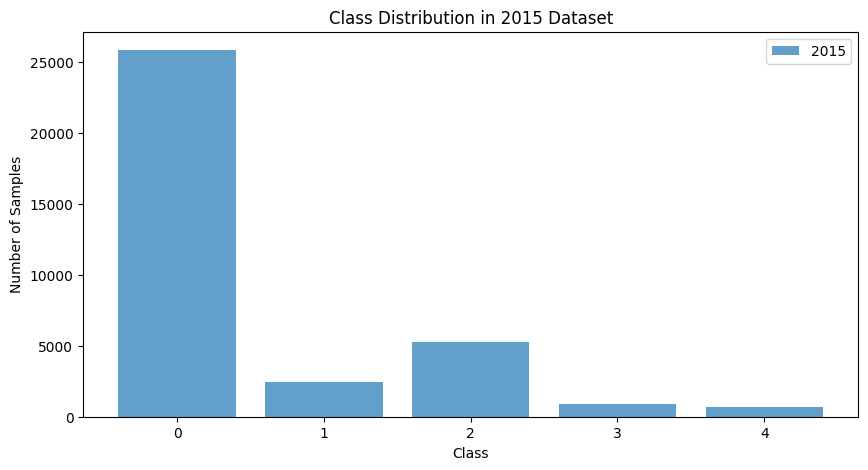

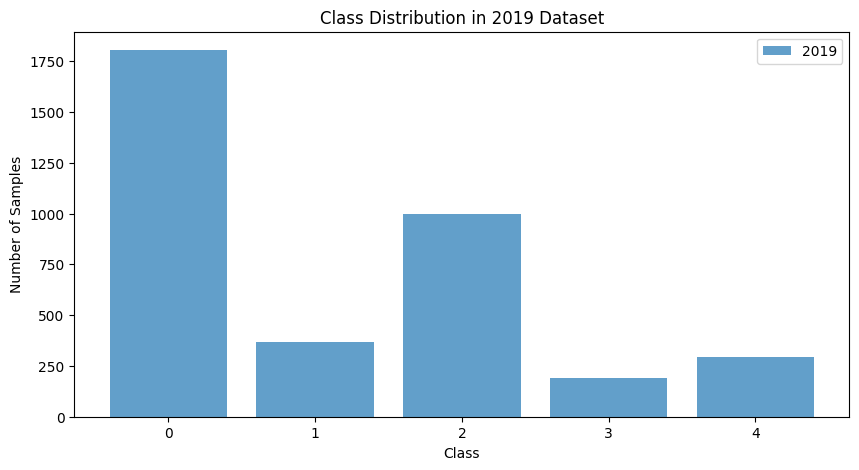

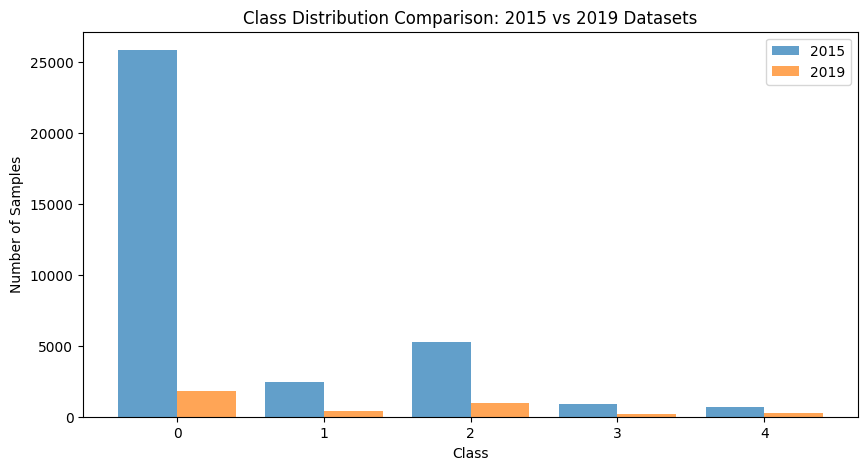

In [5]:
# Plot the distribution of classes in the 2015 dataset
plt.figure(figsize=(10, 5))
plt.bar(class_distribution_2015.index, class_distribution_2015.values, alpha=0.7, label='2015')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in 2015 Dataset')
plt.legend()
plt.show()

# Plot the distribution of classes in the 2019 dataset
plt.figure(figsize=(10, 5))
plt.bar(class_distribution_2019.index, class_distribution_2019.values, alpha=0.7, label='2019')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in 2019 Dataset')
plt.legend()
plt.show()

# Plot the distributions together for comparison
plt.figure(figsize=(10, 5))
plt.bar(class_distribution_2015.index - 0.2, class_distribution_2015.values, width=0.4, alpha=0.7, label='2015')
plt.bar(class_distribution_2019.index + 0.2, class_distribution_2019.values, width=0.4, alpha=0.7, label='2019')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Comparison: 2015 vs 2019 Datasets')
plt.legend()
plt.show()

In [6]:
# Filter Data for Class 4 and Class 0
class_4_indices = [i for i, label in enumerate(labels_2019) if label == 4]
class_4_image_paths = [image_paths_2019[i] for i in class_4_indices]
class_4_labels = [labels_2019[i] for i in class_4_indices]

class_0_indices = [i for i, label in enumerate(labels_2019) if label == 0]
class_0_image_paths = [image_paths_2019[i] for i in class_0_indices]
class_0_labels = [labels_2019[i] for i in class_0_indices]

# Split the datasets into training and validation sets
train_image_paths_4, _, train_labels_4, _ = train_test_split(class_4_image_paths, class_4_labels, test_size=0.2, random_state=42, stratify=class_4_labels)
train_image_paths_0, _, train_labels_0, _ = train_test_split(class_0_image_paths, class_0_labels, test_size=0.2, random_state=42, stratify=class_0_labels)

# Use the full dataset for validation
_, val_image_paths, _, val_labels = train_test_split(image_paths_2019, labels_2019, test_size=0.2, random_state=42, stratify=labels_2019)

In [7]:
# Preprocessing Function
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image, label

# Create Dataset Function
def create_dataset(image_paths, labels, batch_size, buffer_size, is_training=True):
    image_paths = tf.constant(image_paths)
    labels = tf.constant(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Define strategy and batch sizes
BUFFER_SIZE = 500
BATCH_SIZE_PER_REPLICA = 100
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

# Create Datasets
train_ds_class_4 = create_dataset(train_image_paths_4, train_labels_4, BATCH_SIZE, BUFFER_SIZE, is_training=True)
train_ds_class_0 = create_dataset(train_image_paths_0, train_labels_0, BATCH_SIZE, BUFFER_SIZE, is_training=True)

val_ds = create_dataset(val_image_paths, val_labels, BATCH_SIZE, BUFFER_SIZE, is_training=False)

In [8]:
# Load Original Model
model_path = '/home/nate/distributed_training/Keras-Tuner-DR-Distributed-Training/Saved_models/_6_diabetic_retinopathy_model2024-07-10_23-47-53.keras'

# Function to Clone and Train Model
def clone_and_train_model(strategy, model_path, train_ds, val_ds, epochs=1000, class_label=None):
    with strategy.scope():
        # Load the original model within the strategy scope
        original_model = keras.models.load_model(model_path)
        
        # Clone the model
        new_model = keras.models.clone_model(original_model)
        new_model.set_weights(original_model.get_weights())
        
        # Compile the cloned model
        new_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
        
        # Train the model on the specified class dataset
        history = new_model.fit(
            train_ds,
            epochs=epochs,
            validation_data=val_ds,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=140, restore_best_weights=True)]
        )
    
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        model_filename = f'/home/nate/distributed_training/Keras-Tuner-DR-Distributed-Training/Saved_models/class_{class_label}_diabetic_retinopathy_model_{timestamp}.keras'
        new_model.save(model_filename)
        return model_filename, history

# Train and Save Model on Class 4
model_class_4_path, history_class_4 = clone_and_train_model(mirrored_strategy, model_path, train_ds_class_4, val_ds, epochs=1000, class_label=4)

# Train and Save Model on Class 0
model_class_0_path, history_class_0 = clone_and_train_model(mirrored_strategy, model_path, train_ds_class_0, val_ds, epochs=1000, class_label=0)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2024-07-16 21:57:05.586028: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-16 21:57:05.599420: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-16 21:57:05.615233: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-16 21:57:05.640214: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-16 21:57:05.663132: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-16 21:57:10.379761: I external/local_xla/xla/service/service.cc:168] XLA service 0x7cae9884e590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-16 21:57:10.379807: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-16 21:57:10.379822: I external/local_xla/xla/service/service.

1/1 [==============================] - 31s 31s/step - loss: 4.5353 - accuracy: 0.0000e+00 - val_loss: 1.2903 - val_accuracy: 0.4925
Epoch 2/1000
1/1 [==============================] - 1s 1s/step - loss: 2.2885 - accuracy: 0.0000e+00 - val_loss: 1.4068 - val_accuracy: 0.4925
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 1.6514 - accuracy: 0.0000e+00 - val_loss: 1.5247 - val_accuracy: 0.4925
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - loss: 1.4940 - accuracy: 0.0042 - val_loss: 1.5726 - val_accuracy: 0.0805
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - loss: 1.4340 - accuracy: 1.0000 - val_loss: 1.5923 - val_accuracy: 0.0805
Epoch 6/1000
1/1 [==============================] - 1s 1s/step - loss: 1.3392 - accuracy: 1.0000 - val_loss: 1.6404 - val_accuracy: 0.0805
Epoch 7/1000
1/1 [==============================] - 1s 1s/step - loss: 1.1572 - accuracy: 1.0000 - val_loss: 1.7911 - val_accuracy: 0.0805
Epoch 8/1000
1/1 [========

In [9]:
# Plot Training History
def plot_history(history, class_label):
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot(title=f'Loss Curves for Class {class_label}')
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(title=f'Accuracy Curves for Class {class_label}')
    plt.show()

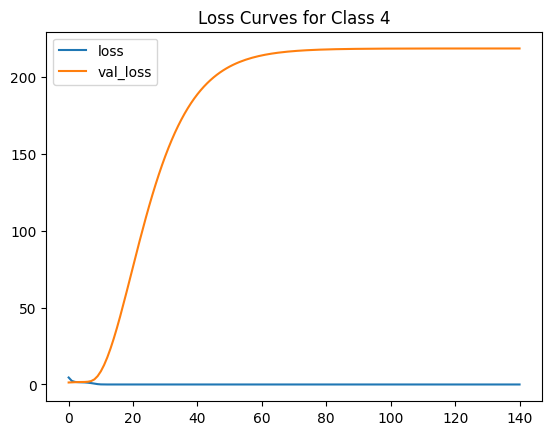

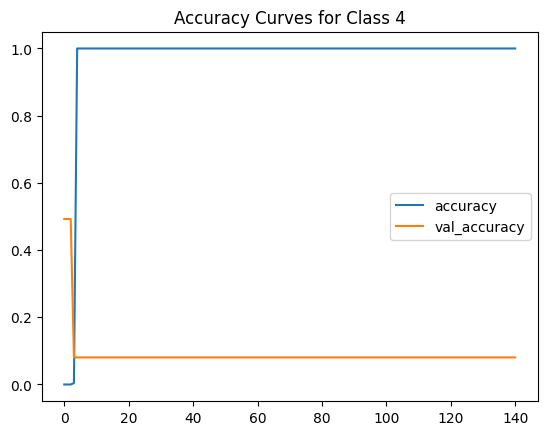

In [10]:
plot_history(history_class_4, class_label=4)

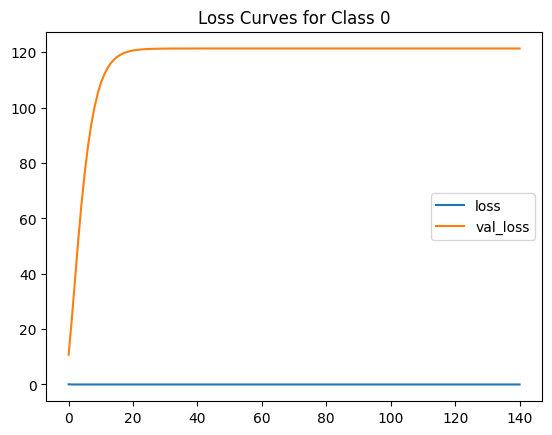

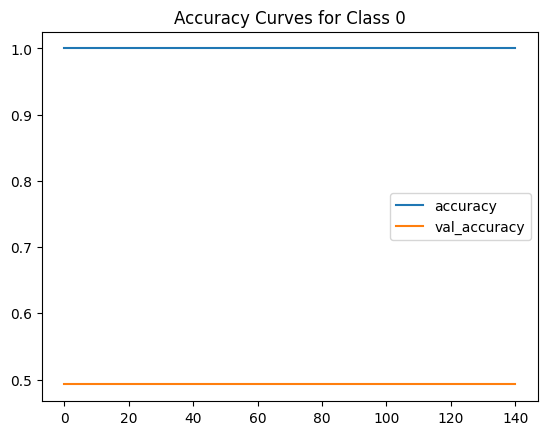

In [11]:
plot_history(history_class_0, class_label=0)